In [1]:
# The code was removed by Watson Studio for sharing.

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [2]:
print('size of train data',train.shape)
print('size of test data',test.shape)

size of train data (15120, 56)
size of test data (565892, 55)


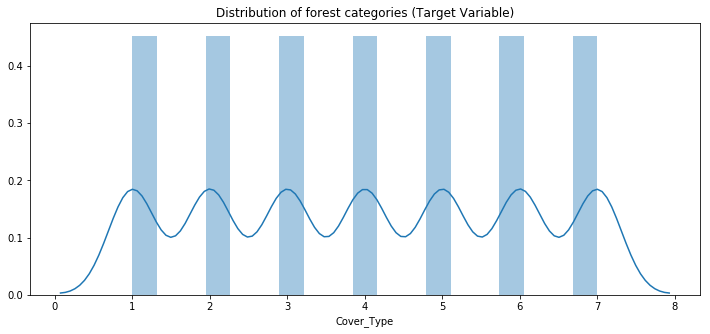

In [3]:
plt.figure(figsize=(12,5))
plt.title("Distribution of forest categories (Target Variable)")
ax = sns.distplot(train["Cover_Type"])

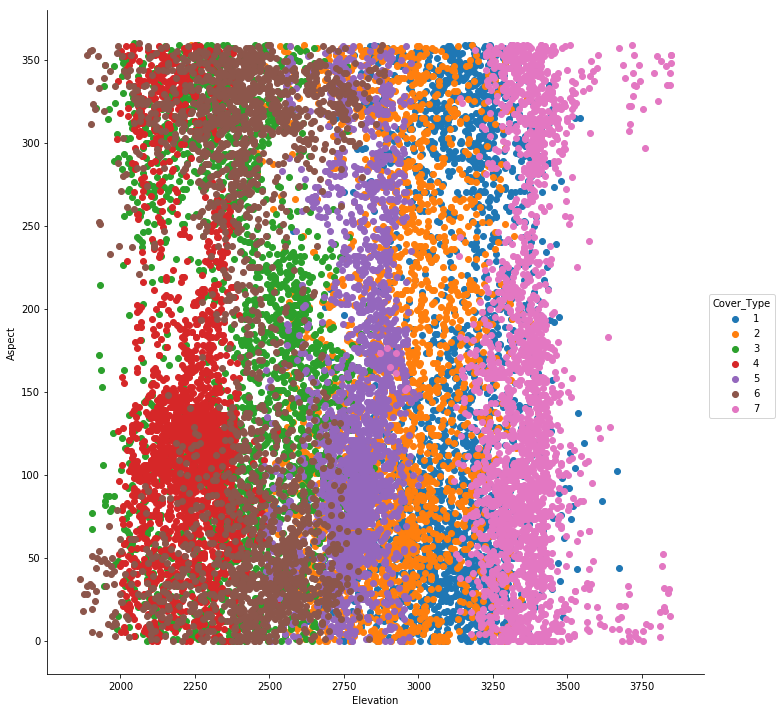

In [4]:
sns.FacetGrid(train, hue="Cover_Type", size=10).map(plt.scatter, "Elevation", "Aspect").add_legend()

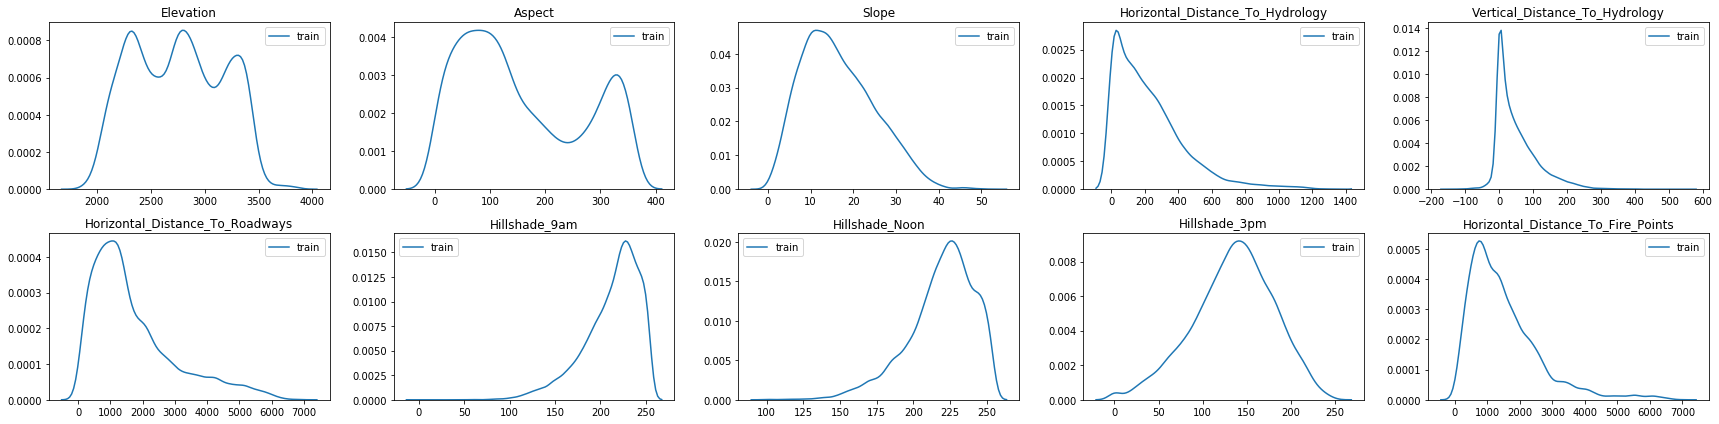

In [7]:
#density plot of features

from scipy.stats import gaussian_kde

def dist(ax, feature, i=0):
    sns.kdeplot(train[feature], label="train", ax=ax)

def numeric_tile(plot_func):
    fig, axs = plt.subplots(2, 5, figsize=(24, 6))
    axs = axs.flatten()
    
    for i, (ax, col) in enumerate(zip(axs, train.columns.tolist()[1:11])):
        plot_func(ax, col, i)
        ax.set_title(col)
    plt.tight_layout()
    
numeric_tile(dist)

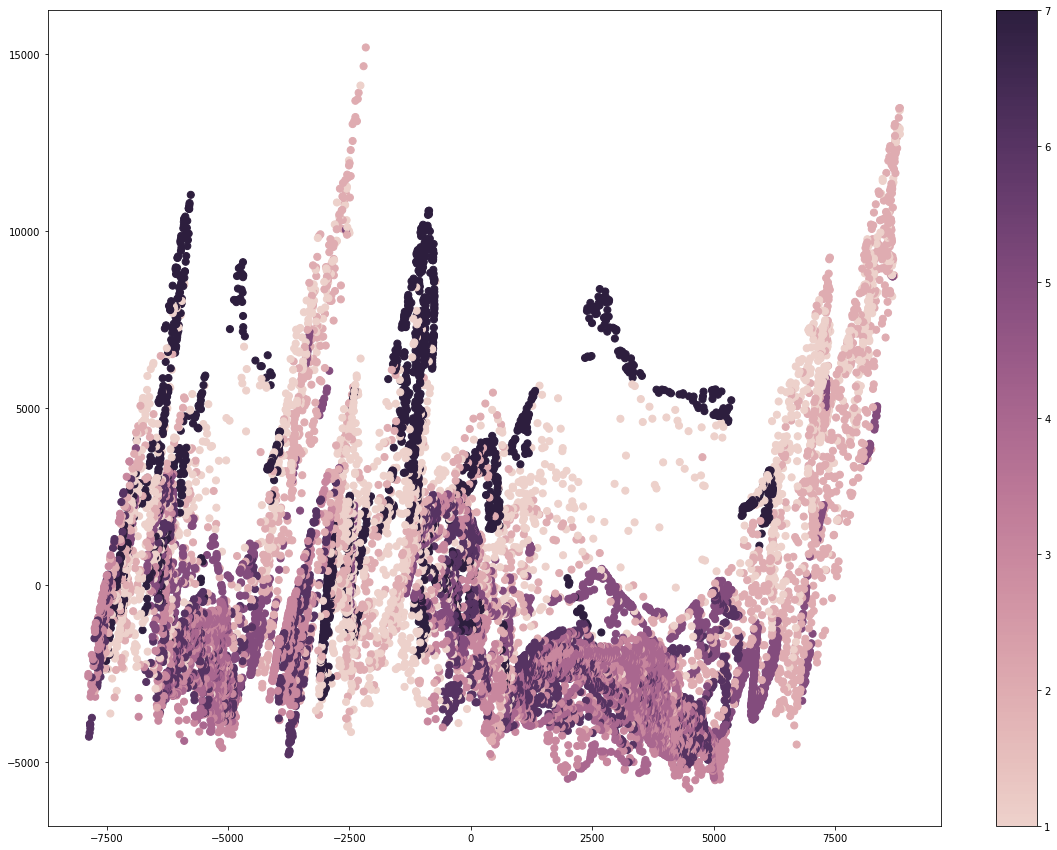

In [80]:
#plot principle compenents 

pca = PCA(n_components=4) 
pca_results = pca.fit_transform(train.drop(["Cover_Type"], axis=1))
cmap = sns.cubehelix_palette(as_cmap=True)
tp, ax = plt.subplots(figsize=(20,15))
temp = ax.scatter(pca_results[:,0], pca_results[:,1], c=train.Cover_Type, s=50, cmap=cmap)
tp.colorbar(temp)
plt.show()

In [65]:
#feature engineering

####################### Train data #######################
train['HF1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
train['HF2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
train['HR1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
train['HR2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
train['FR1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
train['FR2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
train['ele_vert'] = train.Elevation-train.Vertical_Distance_To_Hydrology

train['slope_hyd'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5

# remove infinite values
train.slope_hyd=train.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) 

#Mean distance to Amenities 
train['Mean_Amenities']=(train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + train.Horizontal_Distance_To_Roadways) / 3 

#Mean Distance to Fire and Water 
train['Mean_Fire_Hyd']=(train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology) / 2 

####################### Test data ##########################

test['HF1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']
test['HF2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])
test['HR1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])
test['HR2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])
test['FR1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])
test['FR2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])
test['ele_vert'] = test.Elevation-test.Vertical_Distance_To_Hydrology

# remove infinite value if any
test['slope_hyd'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5
test.slope_hyd=test.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) 

#Mean distance to Amenities 
test['Mean_Amenities']=(test.Horizontal_Distance_To_Fire_Points + test.Horizontal_Distance_To_Hydrology + test.Horizontal_Distance_To_Roadways) / 3 
#Mean Distance to Fire and Water 
test['Mean_Fire_Hyd']=(test.Horizontal_Distance_To_Fire_Points + test.Horizontal_Distance_To_Hydrology) / 2

In [66]:
labels = np.array(train['Cover_Type'])
features = train.drop(['Cover_Type','Id'], axis=1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)


In [67]:
from sklearn import preprocessing

#scale data 
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

In [44]:
#function to plot feature importances 

def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


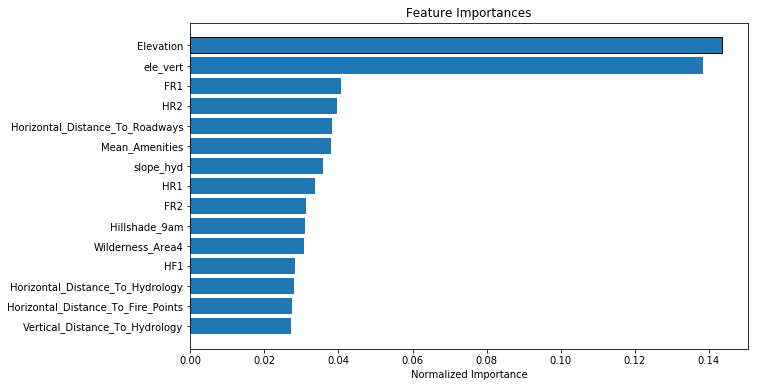

In [45]:
#use simple random forest to derive feature importance

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest.fit(X_train, y_train)

# Feature names
features = list(features.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [ ]:
#baseline model

from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_train)
y_pred_test = model.predict(X_test)
#predictions = y_pred

# evaluate predictions
accuracytrain = accuracy_score(y_train, y_pred)
print("Accuracy: %.2f%%" % (accuracytrain * 100.0))

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [81]:
# Random search: random draws of hyperparameter combinations a set number of times
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
test_dmatrix = xgb.DMatrix(data = X_train, label = y_train)

param_grid = {'gamma': [1],
              "max_depth": [5],
              'learning_rate':np.arange(0.05, 1.05, 0.05) ,
             'n_estimators':[5,10],
             'subsample': np.arange(0.05, 1.05, 0.05)}

gbm = xgb.XGBClassifier(objective = 'binary:logistic')
grid_score2 = RandomizedSearchCV(estimator = gbm, param_distributions= param_grid, n_iter = 1)
grid_score2.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
print(grid_score2.best_params_)
print(grid_score2.best_score_)